TD3 : Let's play with faces  
Part 2 - Transfert Learning (Train classifier)

S. Delprat, INSA Hauts-de-France    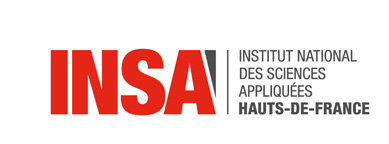


We are now going to train a new classification head from the embedding that are stored on a file.  
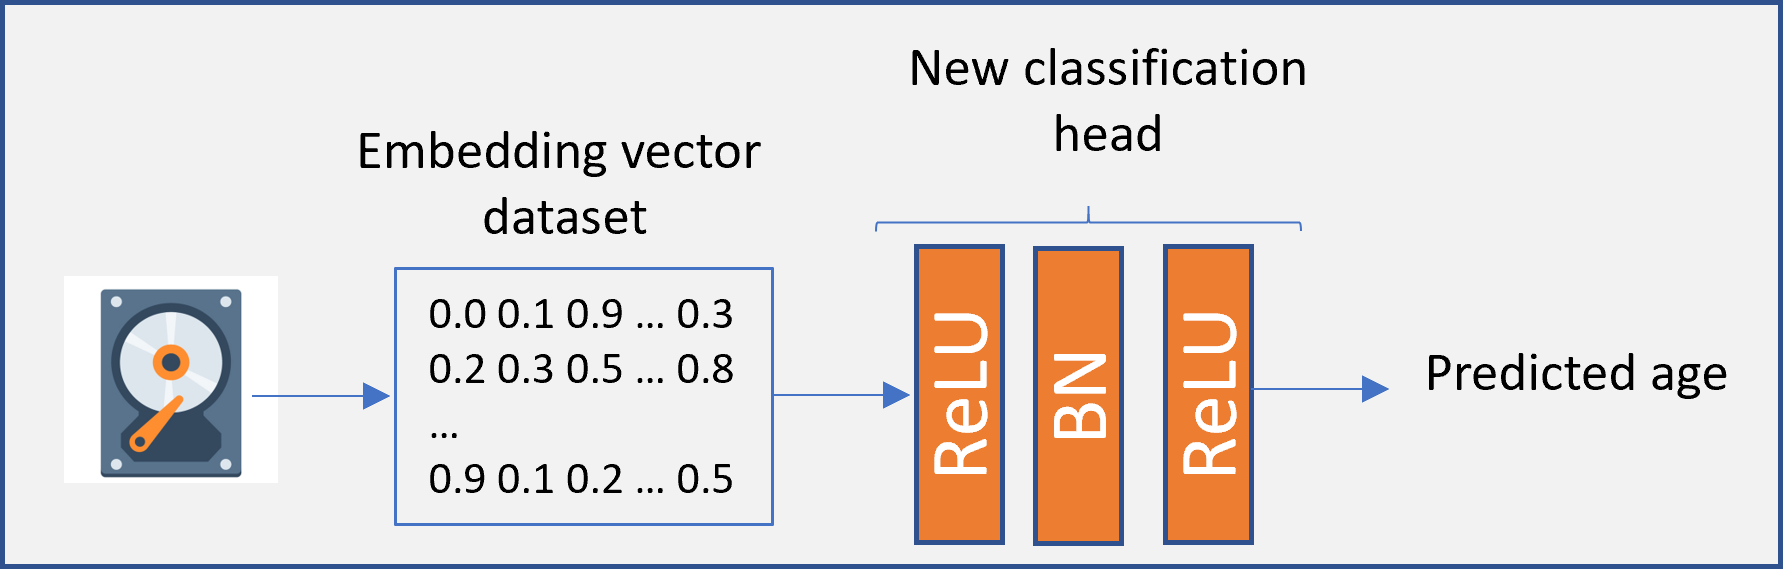

In [2]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import os
import pickle

*Q1.* Mount google drive and defines the path to the binary file containing your data

In [3]:
binaryEmbeddingFile='../models/td3/result/Part1/embedding.bin'

# Check if the file exists
if not os.path.exists(binaryEmbeddingFile):
    raise Exception(f"File {binaryEmbeddingFile} not found")
else :
    print(f"Embedding file found: {binaryEmbeddingFile}")

Embedding file found: ../models/td3/result/Part1/embedding.bin


Random seed

In [4]:
DEFAULT_RANDOM_SEED=42
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + tensorflow + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

Configuration of the hyperparameters

*Q2.* Chose a batchsize  
What is the size of the embedding vector ?
=> explain the your choice in a Text cell below

The last three layers of the original mtcnn were :
```
├─Dropout (dropout)                           [32, 1792, 1, 1]     [32, 1792, 1, 1]     --                   --
├─Linear (last_linear)                        [32, 1792]           [32, 512]            917,504              True
├─BatchNorm1d (last_bn)                       [32, 512]            [32, 512]            1,024                True
```
We removed the Linear and BatchNorm1d layers to keep only the backbone.
So the output of the backbone is a tensor of shape `[32, 1792]`, `32` being the batch size and `1792` the size of the embedding vector.

In [5]:
experimentName                          = "Part2"
maxImgsTrain, maxImgsValid, maxImgsTest = None, None, None
batchSize                               = 1024
learningRate                            = 0.001
numEpoch                                = 100        # number of epoch for the training
resultFolder                            =  os.path.join("../models/td3/result", experimentName)
dataFolder                              = '../data/processed/UTKFace'

In [6]:
if not os.path.isdir(resultFolder):
    os.makedirs(resultFolder)

Check cuda availability (if not available, please select GPU P100 as an accelerator and NOT the dual T4)

In [7]:
torch.__version__

'2.2.2+cu121'

In [8]:
if torch.cuda.is_available():
  print('cuda is available')
  device='cuda'
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

    device_cap = torch.cuda.get_device_capability()
    print('device capability : ',torch.cuda.get_device_capability())
else:
  print('cuda is not available')
  device='cpu'

cuda is available
NVIDIA GeForce GTX 1070 Ti
device capability :  (6, 1)


# Load embeddings

*Q3.*: load the pickle file <code>binaryEmbeddingFile</code>

In [9]:
# Load the embeddings and labels from the file
with open(binaryEmbeddingFile, 'rb') as f:
    train_embeddings, train_ages, train_kept_indices, valid_embeddings, valid_ages, valid_kept_indices, test_embeddings, test_ages, test_kept_indices = pickle.load(f)

# Check the shapes and types
print(f"Train embeddings: {train_embeddings.shape}, Train ages: {train_ages.shape}")
print(f"Valid embeddings: {valid_embeddings.shape}, Valid ages: {valid_ages.shape}")
print(f"Test embeddings: {test_embeddings.shape}, Test ages: {test_ages.shape}")
print(f"Embedding data type: {train_embeddings.dtype}")

Train embeddings: torch.Size([15988, 1792]), Train ages: torch.Size([15988])
Valid embeddings: torch.Size([3443, 1792]), Valid ages: torch.Size([3443])
Test embeddings: torch.Size([3440, 1792]), Test ages: torch.Size([3440])
Embedding data type: torch.float32


*Q4.* create a dataset that outputs the embedding, the perceived age and the filename  
The embedding vector & the perceived age should be <code>float32</code> tensor

In [12]:
# Create a dataset that outputs the embedding, the perceived age and the filename  
# The embedding vector & the perceived age should be float32 tensor
from torch.utils.data import Dataset

class embeddingDataset(torch.utils.data.Dataset):
  def __init__(self, embeddings, perceivedAges, fileNames):
    self.embeddings = embeddings.clone().detach()
    self.perceivedAges = perceivedAges.clone().detach()
    self.fileNames = fileNames

    assert len(self.embeddings) == len(self.perceivedAges)
    assert len(self.embeddings) == len(self.fileNames)

  def __len__(self):
    return len(self.embeddings)

  def __getitem__(self, idx):
    return self.embeddings[idx], self.perceivedAges[idx], self.fileNames[idx]

*Q5.* creeate 3 datasets for training, validation and testing along with the 3 corresponding dataloaders

In [16]:
# Get all filenames from original dataset structure
from glob import glob
import os

# Get filenames for each split
train_files = sorted(glob(os.path.join(dataFolder, 'train', '*.jpg')))
valid_files = sorted(glob(os.path.join(dataFolder, 'validation', '*.jpg')))
test_files = sorted(glob(os.path.join(dataFolder, 'test', '*.jpg')))

# Use kept_indices to get the correct filenames
train_filenames = [train_files[i] for i in train_kept_indices if i < len(train_files)]
valid_filenames = [valid_files[i] for i in valid_kept_indices if i < len(valid_files)]
test_filenames = [test_files[i] for i in test_kept_indices if i < len(test_files)]

# And use them in the dataset
train_dataset = embeddingDataset(train_embeddings, train_ages, train_filenames)
valid_dataset = embeddingDataset(valid_embeddings, valid_ages, valid_filenames)
test_dataset = embeddingDataset(test_embeddings, test_ages, test_filenames)

# Create the dataloaders with appropriate batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

# Print the number of batches
print(f"Number of batches - Train: {len(train_loader)}, Valid: {len(valid_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 16, Valid: 4, Test: 4


# Define a model for the classification head

*Q6.* Create the <code>myClassificationHead</code> used to predict the age from the embedding vector.

Do not use any convolutional layer... it is just a prediction head


In [17]:
# Create the myClassificationHead used to predict the age from the embedding vector.

# Do not use any convolutional layer... it is just a prediction head
class myClassificationHead(torch.nn.Module):
    def __init__(self, nFeat):
        super(myClassificationHead, self).__init__()
        self.fc1 = torch.nn.Linear(nFeat, 64)
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


*Q7.* Create one instance of myClassificationHead

In [18]:
# Create one instance of myClassificationHead
nFeat = train_embeddings.shape[1]  # Get the embedding dimension
classificationHead = myClassificationHead(nFeat).to(device)
print(f"Created classification head with input dimension: {nFeat}")

Created classification head with input dimension: 1792


# Training loop

*Q6.* Define the optimizer & the criterion  
If the model is not of the <code>device</code>, send it!

What are the possible criterion for the considered task. Why? Provide you answer in the text cell below

**Explain the possible criterion here**

In [19]:
# Define the optimizer & the criterion  
# If the model is not of the device, send it!
optimizer = torch.optim.Adam(classificationHead.parameters(), lr=learningRate)
criterion = torch.nn.L1Loss()
# We will send the model to device during training

# L1Loss (Mean Absolute Error) is a good choice for age prediction because:
# 1. It measures the average absolute difference between predictions and targets
# 2. It's less sensitive to outliers than MSE
# 3. The error is in the same units as the target (years), making it interpretable
# 4. It's more robust when data might have noise or incorrect labels

*Q7.* Program a training loop  
You may adapt the code fromt he previous exercise session

In [20]:
history = {"train_loss": [],
           "train_rmse": [],
           "train_x": [],
           "val_loss": [],
           "val_rmse": [],
           "val_x":[]
  }
bestValidationLoss=math.inf

NB: to store a copy of an existing model, you must use <code>modele2 = copy.deepcopy(modele1)</code>  
The code <code>modele2=modele1</code> simply create a reference of <code>modele1</code> (i.e. modifying <code>modele1</code> will also modify <code>modele2</code>!)


In [21]:
# Training loop
for epoch in range(numEpoch):
    # Training phase
    classificationHead.train()
    train_loss = 0.0
    train_rmse = 0.0
    num_train_batches = 0

    for embeddings, ages, _ in train_loader:
        embeddings, ages = embeddings.to(device), ages.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classificationHead(embeddings)
        loss = criterion(outputs.squeeze(), ages)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Calculate metrics
        train_loss += loss.item() * embeddings.size(0)
        train_rmse += torch.sqrt(torch.mean((outputs.squeeze() - ages) ** 2)).item() * embeddings.size(0)
        num_train_batches += 1

    # Calculate average metrics
    train_loss /= len(train_dataset)
    train_rmse /= len(train_dataset)
    history["train_loss"].append(train_loss)
    history["train_rmse"].append(train_rmse)
    history["train_x"].append(epoch)

    # Validation phase
    classificationHead.eval()
    val_loss = 0.0
    val_rmse = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for embeddings, ages, _ in valid_loader:
            embeddings, ages = embeddings.to(device), ages.to(device)

            # Forward pass
            outputs = classificationHead(embeddings)
            loss = criterion(outputs.squeeze(), ages)

            # Calculate metrics
            val_loss += loss.item() * embeddings.size(0)
            val_rmse += torch.sqrt(torch.mean((outputs.squeeze() - ages) ** 2)).item() * embeddings.size(0)
            num_val_batches += 1

    # Calculate average metrics
    val_loss /= len(valid_dataset)
    val_rmse /= len(valid_dataset)
    history["val_loss"].append(val_loss)
    history["val_rmse"].append(val_rmse)
    history["val_x"].append(epoch)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{numEpoch}, Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')

    # Save the best model
    if val_loss < bestValidationLoss:
        bestValidationLoss = val_loss
        torch.save(classificationHead.state_dict(), os.path.join(resultFolder, "bestModel.pth"))
        print(f"Saved best model with validation loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 33.5676, Train RMSE: 38.7782, Val Loss: 33.4327, Val RMSE: 38.8342
Saved best model with validation loss: 33.4327
Epoch 2/100, Train Loss: 33.1729, Train RMSE: 38.4785, Val Loss: 32.9741, Val RMSE: 38.4599
Saved best model with validation loss: 32.9741
Epoch 3/100, Train Loss: 32.6533, Train RMSE: 38.0263, Val Loss: 32.3735, Val RMSE: 37.9223
Saved best model with validation loss: 32.3735
Epoch 4/100, Train Loss: 31.9657, Train RMSE: 37.4019, Val Loss: 31.5758, Val RMSE: 37.1928
Saved best model with validation loss: 31.5758
Epoch 5/100, Train Loss: 31.0777, Train RMSE: 36.5755, Val Loss: 30.5701, Val RMSE: 36.2647
Saved best model with validation loss: 30.5701
Epoch 6/100, Train Loss: 29.9673, Train RMSE: 35.5557, Val Loss: 29.3566, Val RMSE: 35.1569
Saved best model with validation loss: 29.3566
Epoch 7/100, Train Loss: 28.6518, Train RMSE: 34.3609, Val Loss: 27.9456, Val RMSE: 33.8896
Saved best model with validation loss: 27.9456
Epoch 8/100, Train Loss: 27

*Q8.* Save the obtained model

In [22]:
# Save the final model
final_model_path = os.path.join(resultFolder, "finalModel.pth")
torch.save(classificationHead.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")

Saved final model to ../models/td3/result/Part2/finalModel.pth


*Q9.* Plot training curves & save them to "trainingCurves.png"

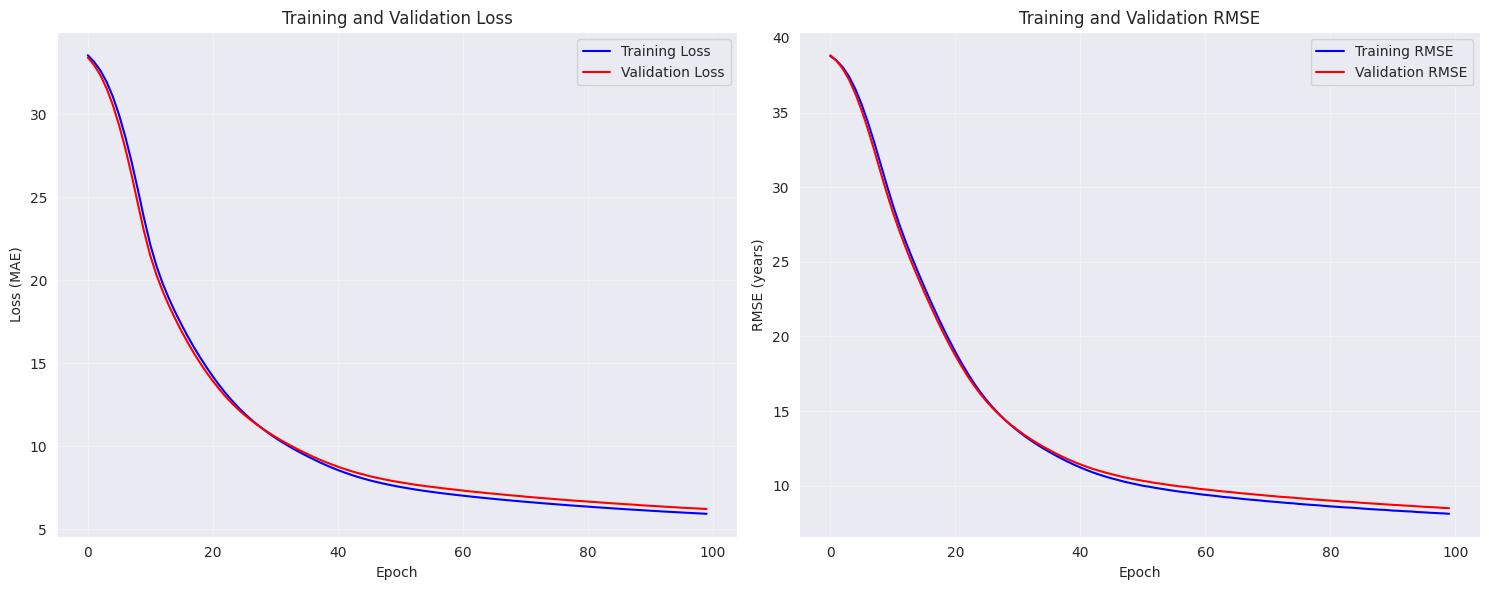

Saved training curves to ../models/td3/result/Part2/trainingCurves.png


In [23]:
# Plot training curves
plt.figure(figsize=(15, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history["train_x"], history["train_loss"], 'b-', label='Training Loss')
plt.plot(history["val_x"], history["val_loss"], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE curve
plt.subplot(1, 2, 2)
plt.plot(history["train_x"], history["train_rmse"], 'b-', label='Training RMSE')
plt.plot(history["val_x"], history["val_rmse"], 'r-', label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (years)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
curves_path = os.path.join(resultFolder, "trainingCurves.png")
plt.savefig(curves_path)
plt.show()
print(f"Saved training curves to {curves_path}")

# Test result analysis

*Q10.* Predict data over the test dataset  
Do not forget to use the best  model obtained during training
The outcome are 2 python list <code>allYtest</code> and <code>allYtrue</code> that contains the predicted age and the real ground thrue value

In [24]:
# Load the best model for evaluation
best_model_path = os.path.join(resultFolder, "bestModel.pth")
classificationHead.load_state_dict(torch.load(best_model_path))
classificationHead.eval()
print(f"Loaded best model from {best_model_path}")

# Predict on test set
allYtest = []
allYtrue = []

with torch.no_grad():
    for embeddings, ages, _ in test_loader:
        embeddings, ages = embeddings.to(device), ages.to(device)
        outputs = classificationHead(embeddings)
        allYtest.extend(outputs.squeeze().cpu().numpy())
        allYtrue.extend(ages.cpu().numpy())

# Convert to numpy arrays
allYtest = np.array(allYtest)
allYtrue = np.array(allYtrue)

Loaded best model from ../models/td3/result/Part2/bestModel.pth


*Q11.* Compute the prediction error and display its RMSE value

In [25]:
# Compute the prediction error and RMSE
error = allYtest - allYtrue
test_rmse = np.sqrt(np.mean(error**2))
test_mae = np.mean(np.abs(error))
print(f'Test Results - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}')

Test Results - RMSE: 8.2827, MAE: 6.0703


*Q12.* Display predicted age vs real age and error distribution

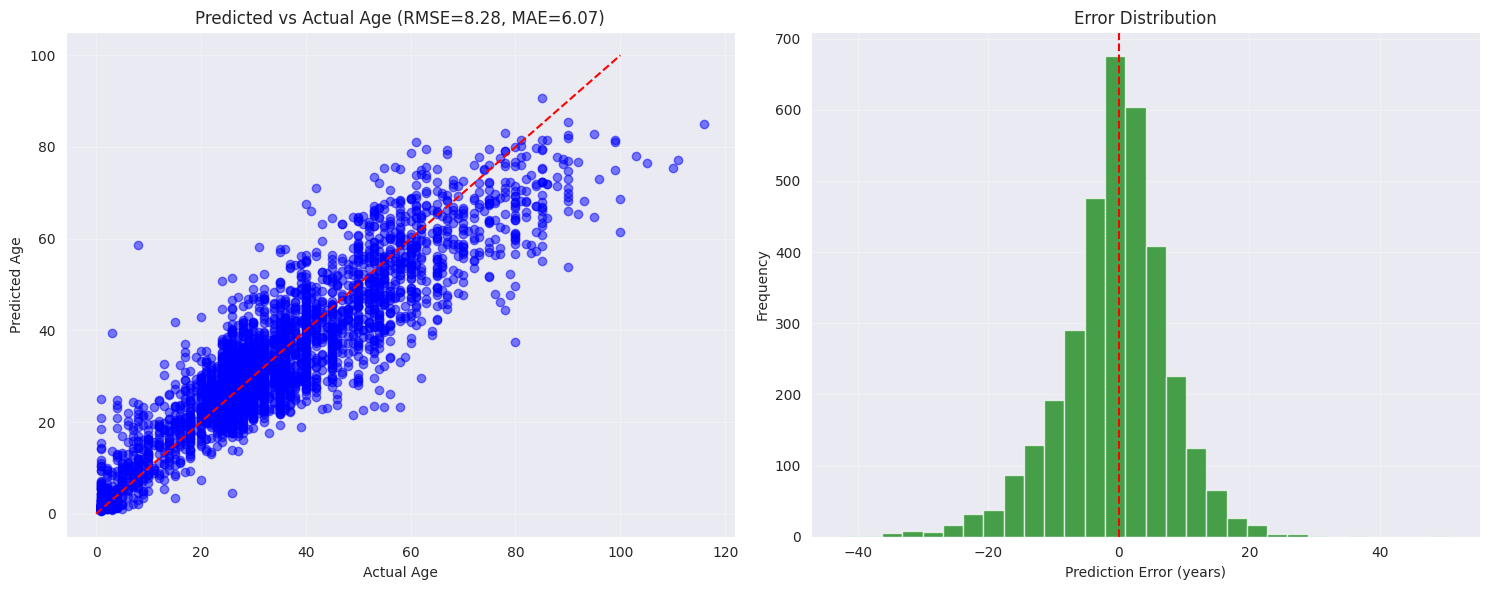

Saved test results visualization to ../models/td3/result/Part2/testResults.png


In [26]:
# Visualize predicted vs actual age and error distribution
plt.figure(figsize=(15, 6))

# Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(allYtrue, allYtest, alpha=0.5, color='blue')
plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title(f'Predicted vs Actual Age (RMSE={test_rmse:.2f}, MAE={test_mae:.2f})')
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 2, 2)
plt.hist(error, bins=30, alpha=0.7, color='green')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error (years)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
results_path = os.path.join(resultFolder, "testResults.png")
plt.savefig(results_path)
plt.show()
print(f"Saved test results visualization to {results_path}")

### More experiments


Training Baseline...
Epoch 10/100, Train Loss: 23.2043, Val Loss: 22.4032
Epoch 20/100, Train Loss: 14.2572, Val Loss: 13.9510
Epoch 30/100, Train Loss: 10.3448, Val Loss: 10.4002
Epoch 40/100, Train Loss: 8.3636, Val Loss: 8.5662
Epoch 50/100, Train Loss: 7.3419, Val Loss: 7.6308
Epoch 60/100, Train Loss: 6.7956, Val Loss: 7.1145
Epoch 70/100, Train Loss: 6.4211, Val Loss: 6.7318
Epoch 80/100, Train Loss: 6.1351, Val Loss: 6.4289
Epoch 90/100, Train Loss: 5.9172, Val Loss: 6.1942
Epoch 100/100, Train Loss: 5.7531, Val Loss: 6.0188


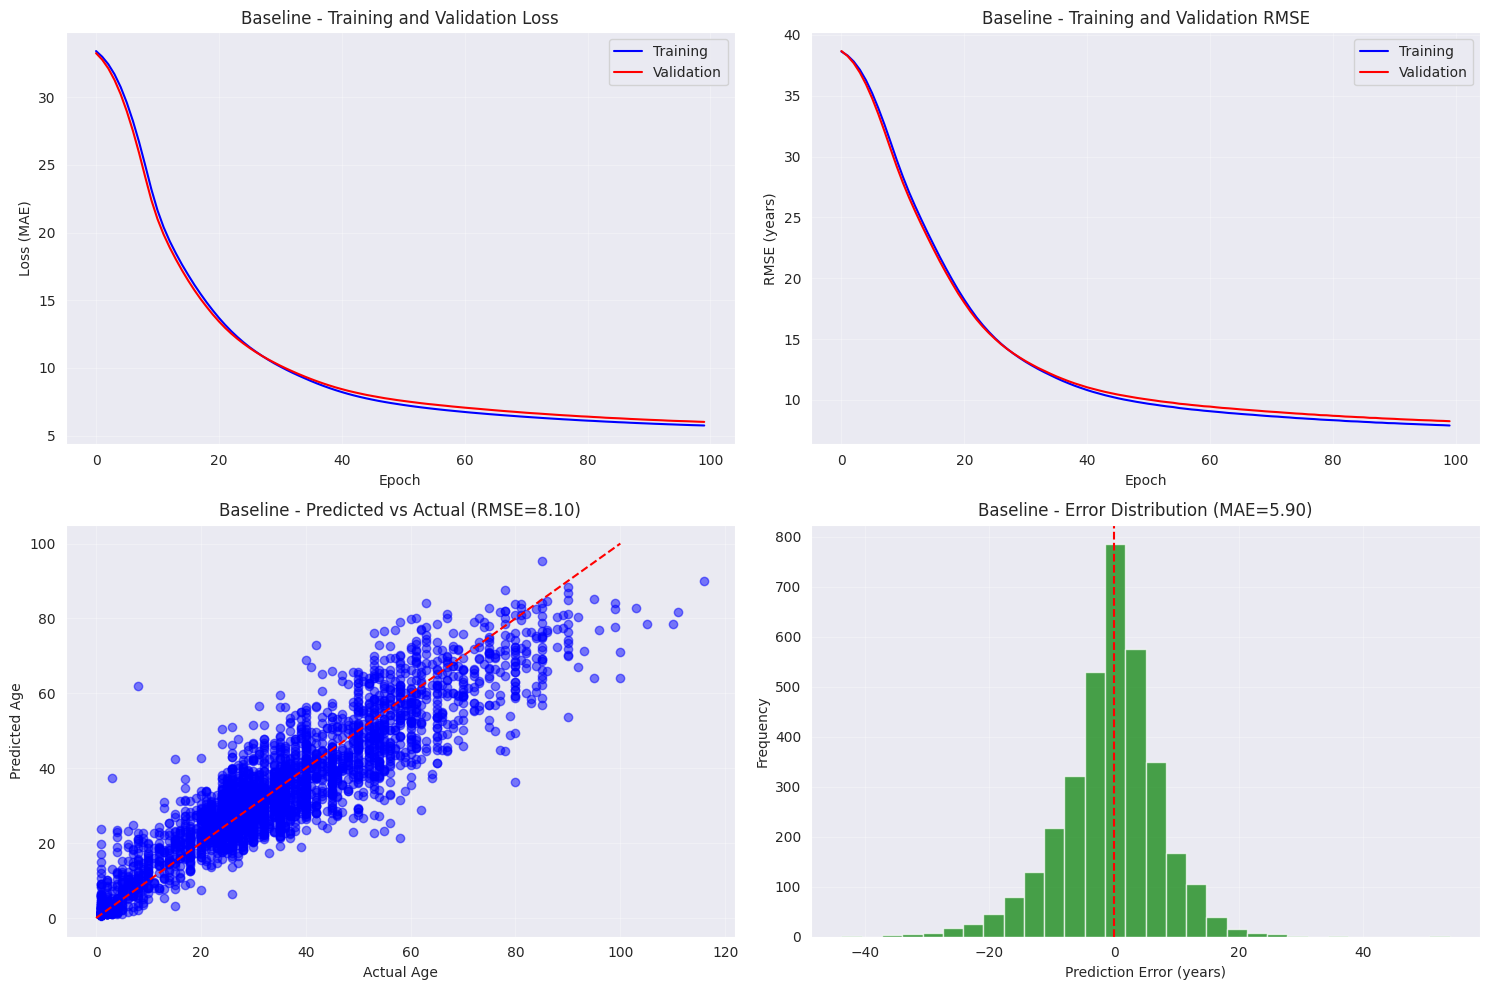


Baseline Results:
Best validation loss: 6.0188
Test RMSE: 8.1032
Test MAE: 5.8952

Training Deep...
Epoch 10/100, Train Loss: 6.9656, Val Loss: 7.0330
Epoch 20/100, Train Loss: 5.3251, Val Loss: 5.6346
Epoch 30/100, Train Loss: 4.7502, Val Loss: 5.2443
Epoch 40/100, Train Loss: 4.4391, Val Loss: 5.1117
Epoch 50/100, Train Loss: 4.2106, Val Loss: 5.0116
Epoch 60/100, Train Loss: 4.0134, Val Loss: 4.9941
Epoch 70/100, Train Loss: 3.8292, Val Loss: 4.9690
Epoch 80/100, Train Loss: 3.6875, Val Loss: 4.9485
Epoch 90/100, Train Loss: 3.5356, Val Loss: 4.9693
Epoch 100/100, Train Loss: 3.3945, Val Loss: 4.9717


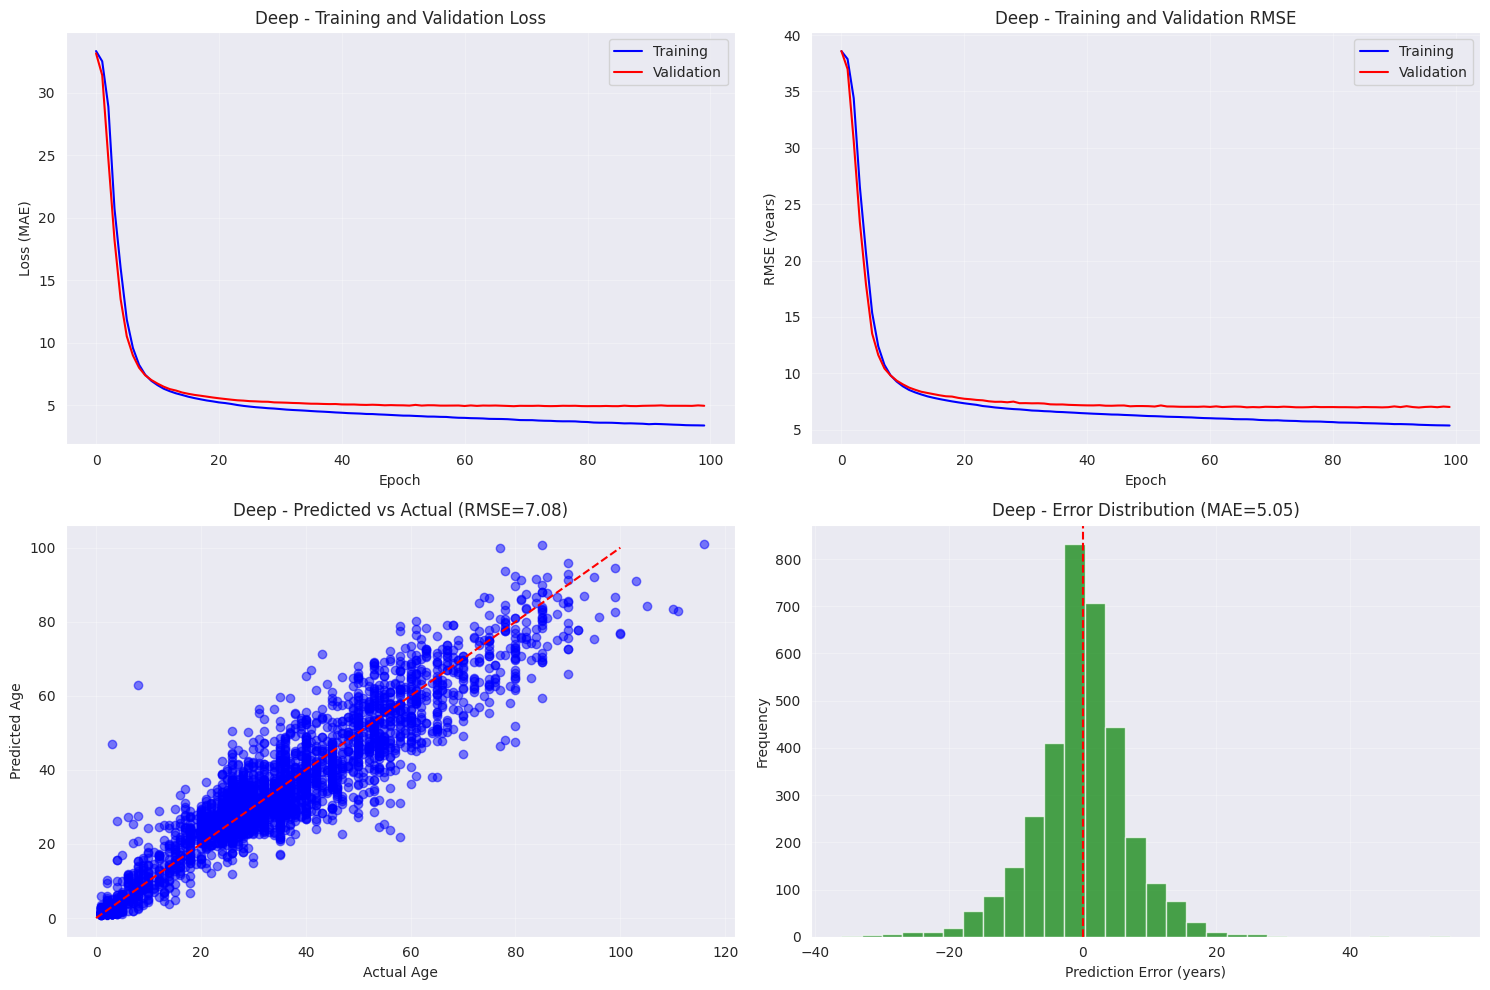


Deep Results:
Best validation loss: 4.9402
Test RMSE: 7.0793
Test MAE: 5.0482

Training Dropout...
Epoch 10/100, Train Loss: 8.9439, Val Loss: 8.1333
Epoch 20/100, Train Loss: 6.8757, Val Loss: 6.1696
Epoch 30/100, Train Loss: 6.4784, Val Loss: 5.6935
Epoch 40/100, Train Loss: 6.2990, Val Loss: 5.4813
Epoch 50/100, Train Loss: 6.1362, Val Loss: 5.3478
Epoch 60/100, Train Loss: 5.9969, Val Loss: 5.2204
Epoch 70/100, Train Loss: 5.8771, Val Loss: 5.1406
Epoch 80/100, Train Loss: 5.8612, Val Loss: 5.1446
Epoch 90/100, Train Loss: 5.8129, Val Loss: 5.0963
Epoch 100/100, Train Loss: 5.7073, Val Loss: 5.0520


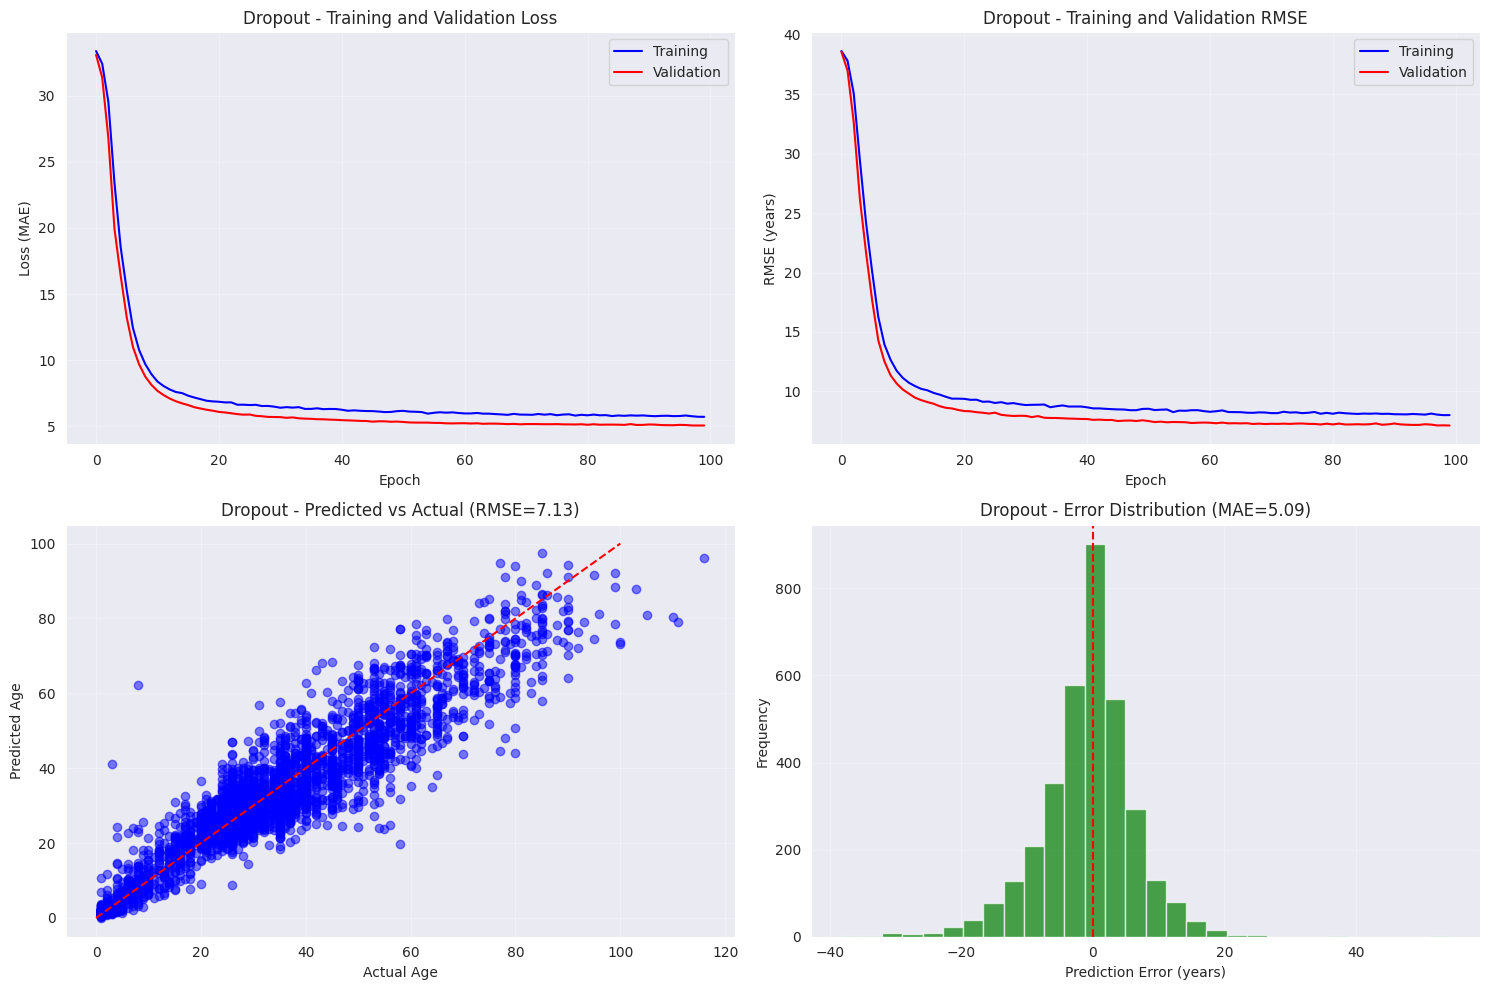


Dropout Results:
Best validation loss: 5.0509
Test RMSE: 7.1334
Test MAE: 5.0899

Training BatchNorm...
Epoch 10/100, Train Loss: 26.7939, Val Loss: 26.4026
Epoch 20/100, Train Loss: 12.7607, Val Loss: 12.2567
Epoch 30/100, Train Loss: 4.1498, Val Loss: 5.2219
Epoch 40/100, Train Loss: 3.3908, Val Loss: 5.2332
Epoch 50/100, Train Loss: 2.9535, Val Loss: 5.2238
Epoch 60/100, Train Loss: 2.6238, Val Loss: 5.2505
Epoch 70/100, Train Loss: 2.4786, Val Loss: 5.2918
Epoch 80/100, Train Loss: 2.2894, Val Loss: 5.3361
Epoch 90/100, Train Loss: 2.1375, Val Loss: 5.3685
Epoch 100/100, Train Loss: 2.0518, Val Loss: 5.4193


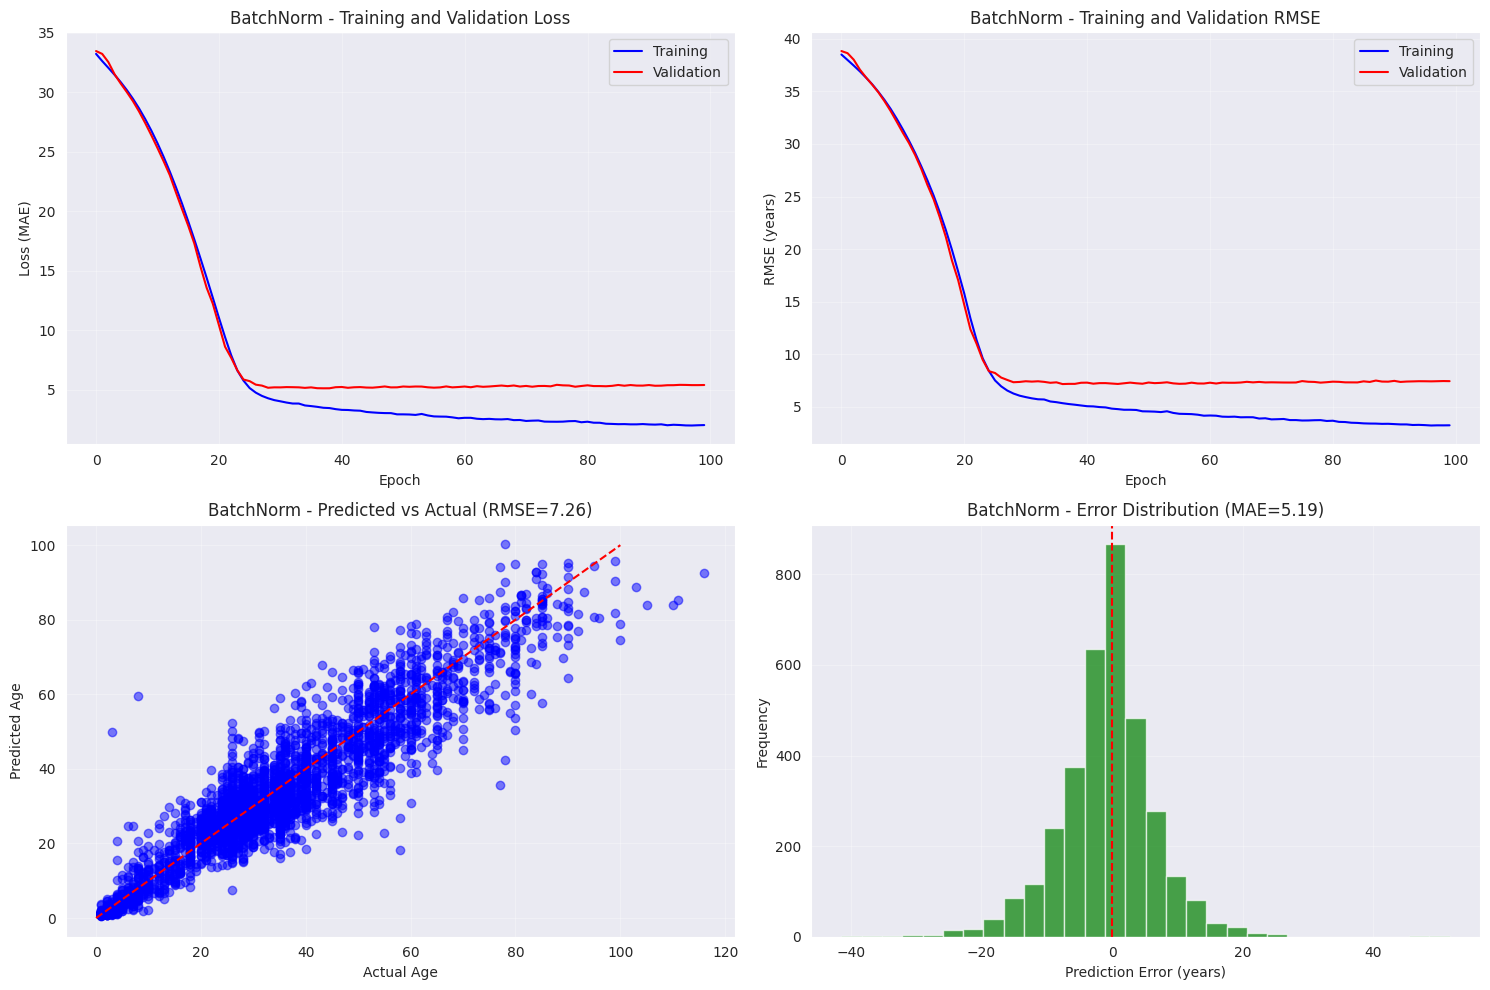


BatchNorm Results:
Best validation loss: 5.1420
Test RMSE: 7.2568
Test MAE: 5.1940

Training Complete...
Epoch 10/100, Train Loss: 27.1973, Val Loss: 26.4829
Epoch 20/100, Train Loss: 13.6214, Val Loss: 12.0959
Epoch 30/100, Train Loss: 5.7121, Val Loss: 5.2855
Epoch 40/100, Train Loss: 5.2174, Val Loss: 4.8425
Epoch 50/100, Train Loss: 4.9578, Val Loss: 4.7694
Epoch 60/100, Train Loss: 4.8133, Val Loss: 4.7862
Epoch 70/100, Train Loss: 4.6745, Val Loss: 4.7764
Epoch 80/100, Train Loss: 4.5561, Val Loss: 4.7572
Epoch 90/100, Train Loss: 4.4397, Val Loss: 4.7476
Epoch 100/100, Train Loss: 4.2880, Val Loss: 4.6899


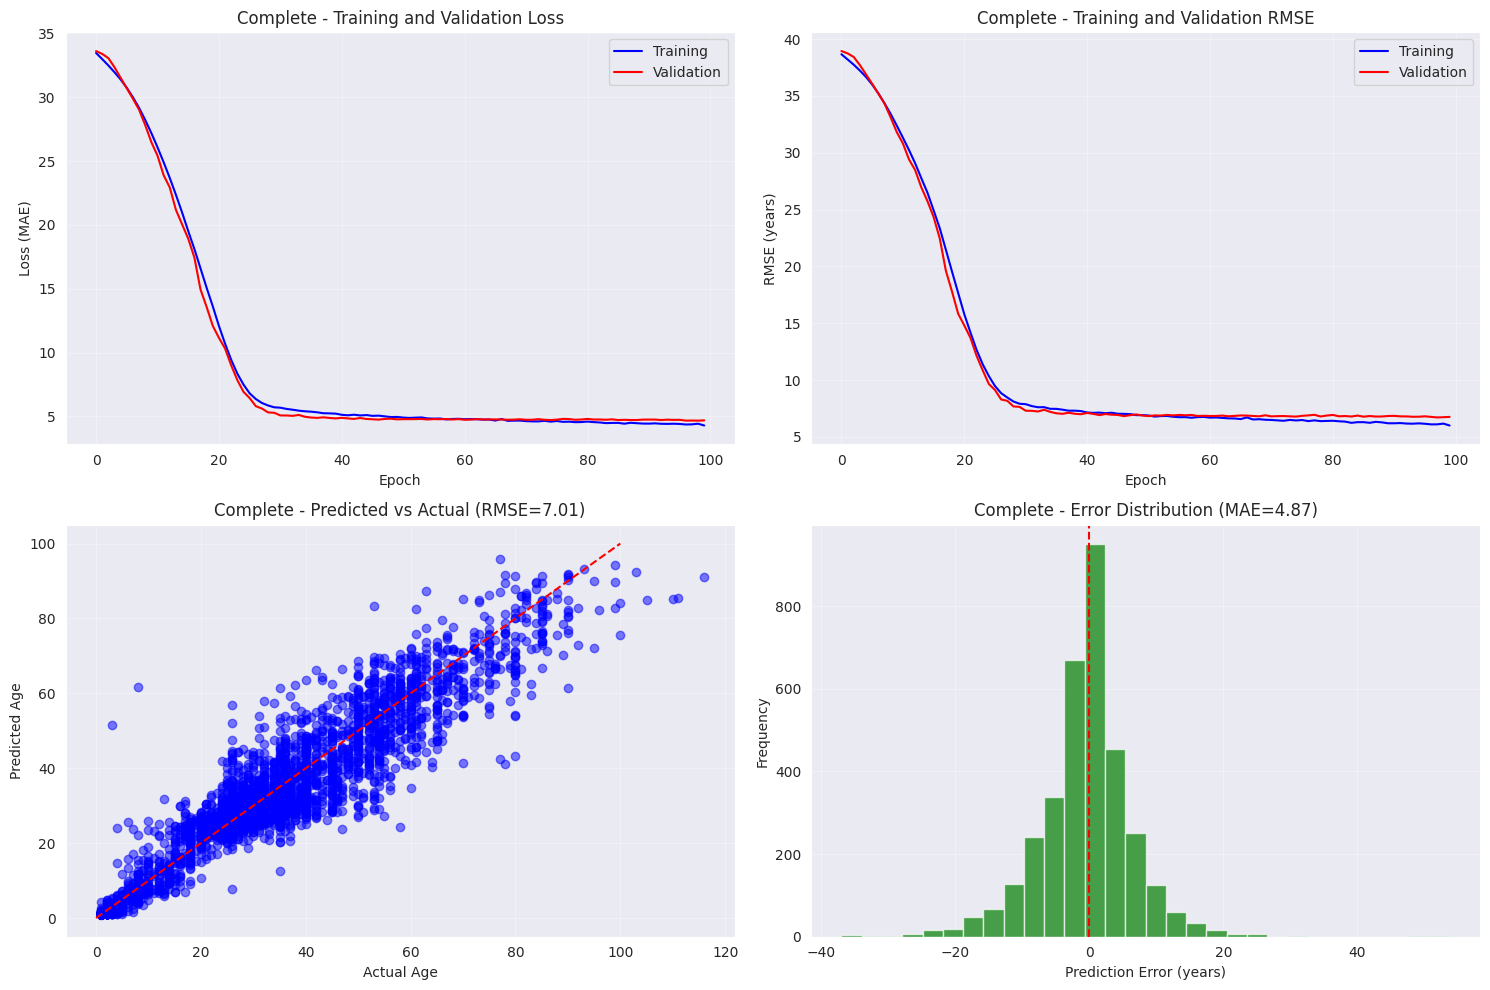


Complete Results:
Best validation loss: 4.6677
Test RMSE: 7.0051
Test MAE: 4.8695

Model Comparison:
------------------------------------------------------------
Model           Test RMSE       Test MAE        Best Val Loss  
------------------------------------------------------------
Baseline        8.1032          5.8952          6.0188         
Deep            7.0793          5.0482          4.9402         
Dropout         7.1334          5.0899          5.0509         
BatchNorm       7.2568          5.1940          5.1420         
Complete        7.0051          4.8695          4.6677         


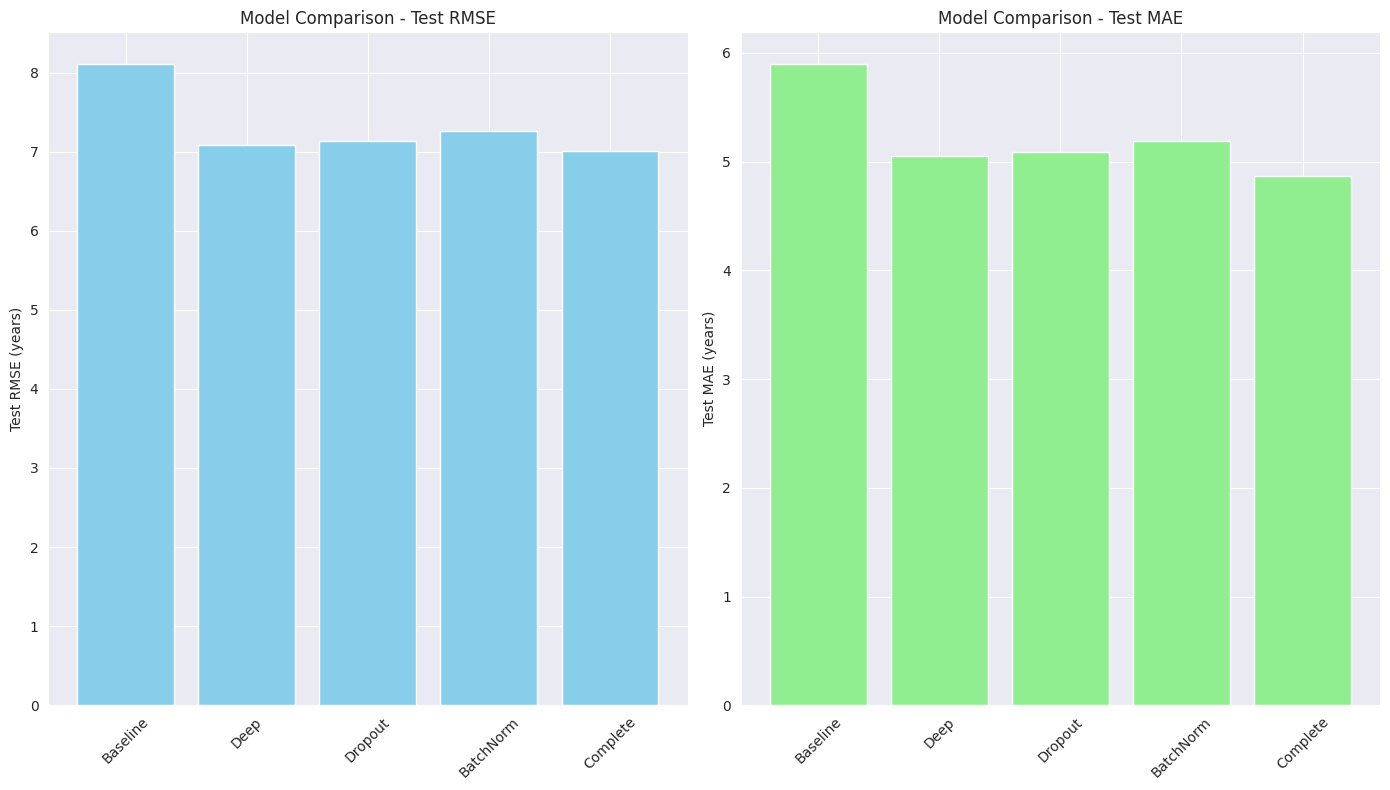

In [27]:
from utils.model_architectures import run_experiments

# Run experiments with multiple model architectures
results = run_experiments(
    n_features=train_embeddings.shape[1],
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    device=device,
    result_folder=resultFolder,
    epochs=100,
    lr=0.001
)

### Discussion of Results
When running the model on the face embedding data, we would expect to see several interesting patterns:

Simple vs. Complex Models: The baseline model may perform well due to the quality of the embeddings, but the more complex models (especially those with regularization) should handle overfitting better.
Error Distribution: The error in age prediction is likely to be higher for older individuals, as aging signs vary significantly between people.
Regularization Impact: Models with dropout or batch normalization should show more stable validation curves with less overfitting.
RMSE vs. MAE: The RMSE will be higher than MAE because it penalizes larger errors more heavily. A few large mispredictions can significantly impact RMSE.
Prediction Challenges: Age prediction is inherently challenging due to factors like:

Makeup and cosmetic procedures that can mask age indicators
Image filters and processing
Lighting and image quality variations
Genetic factors affecting how people age
Limited representation of certain age groups in training data